In [0]:
!pip install tf-nightly-gpu-2.0-preview

import tensorflow as tf
from matplotlib import pyplot as plt

In [0]:
# Import and reshape data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

image_size = x_train.shape[1]
assert image_size == x_train.shape[2]
original_dim = image_size * image_size

x_train = x_train.reshape([-1, original_dim])
x_test = x_test.reshape([-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [0]:
# Set network parameters

input_shape = (original_dim, )
intermediate_dim = 512
latent_dim = 2
batch_size = 128
epochs = 50

In [0]:
class Sampling(tf.keras.layers.Layer):
  
  def call(self, inputs):
    mean, log_var = inputs
    batch_size = tf.shape(mean)[0]
    dim = tf.shape(mean)[1]
    rand_normal = tf.random_normal_initializer()
    epsilon = rand_normal(shape=(batch_size, dim))
    return mean + tf.exp(0.5 * log_var)*epsilon

# Build Encoder network
inputs = tf.keras.Input(shape=input_shape, name='encoder_input')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = tf.keras.layers.Dense(latent_dim, name='z_mean')(x)
z_log_var = tf.keras.layers.Dense(latent_dim, name='z_log_var')(x)
z = Sampling()((z_mean, z_log_var))
encoder = tf.keras.Model(inputs, [z_mean, z_log_var, z], name='encoder')

encoder.summary()
#tf.keras.utils.plot_model(encoder, to_file="vae_encoder.png", show_shapes=True)

# Build Decoder network
latent_inputs = tf.keras.Input(shape=(latent_dim,), name = 'z_sampling')
x = tf.keras.layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = tf.keras.layers.Dense(input_dim, activation='relu')(x)
decoder = tf.keras.Model(latent_inputs, outputs, name='decoder')

decoder.summary()

# Build the VAE
outputs = decoder(encoder(inputs)[2])
vae = tf.keras.Model(inputs, outputs, name='vae')
vae.summary()

In [0]:
models = (encoder, decoder)
data = (x_test, y_test)

# Add loss (reconstruction_loss and KL divergence)
reconstruction_loss = tf.keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = -0.5 * tf.reduce_sum(kl_loss)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)

vae.compile(optimizer='adam')
vae.summary()
tf.keras.utils.plot_model(vae, "vae.png", show_shapes=True)

In [73]:
# Train the model
vae.fit(x_train,
       epochs=epochs,
       batch_size=batch_size,
       validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 15s 251us/sample - loss: 602.5934 - val_loss: 576.2423
Epoch 2/50
60000/60000 [==============================] - 14s 235us/sample - loss: 532.3440 - val_loss: 517.3181
Epoch 3/50
60000/60000 [==============================] - 14s 239us/sample - loss: 513.3293 - val_loss: 508.1013
Epoch 4/50
60000/60000 [==============================] - 14s 237us/sample - loss: 511.0381 - val_loss: 502.9641
Epoch 5/50
60000/60000 [==============================] - 14s 234us/sample - loss: 504.6712 - val_loss: 500.7244
Epoch 6/50
60000/60000 [==============================] - 14s 234us/sample - loss: 494.4625 - val_loss: 486.5827
Epoch 7/50
60000/60000 [==============================] - 14s 233us/sample - loss: 486.5547 - val_loss: 473.7686
Epoch 8/50
60000/60000 [==============================] - 14s 234us/sample - loss: 476.5787 - val_loss: 473.1376
Epoch 9/50
60000/60000 [======================

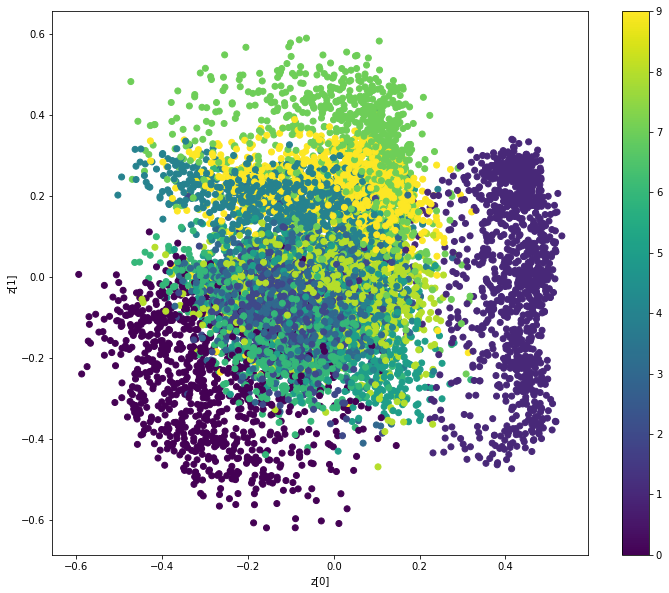

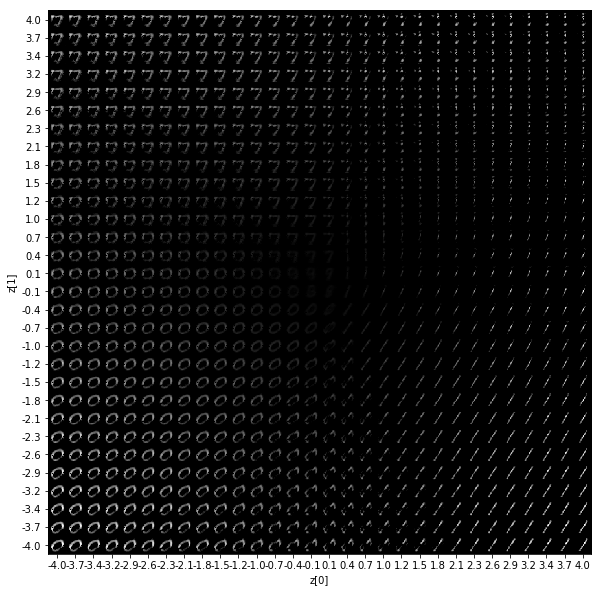

In [75]:
import numpy as np
plot_results(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp")

In [0]:
import os

def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()